In [1]:
# 设置Python路径以导入自定义模块
import sys
import os
import importlib

# 获取项目根目录的绝对路径
project_root = '/home/Huyy/workspace/code/component_zj/HighEntropyAlloy/HighEntropyAlloy_zj/project'
# 将项目根目录添加到Python路径中
# sys.path 包含了 Python 解释器查找模块的路径列表。根据代码中的设置，sys.path 应该包含以下内容：
# 1. 项目根目录：/home/Huyy/workspace/code/component_zj/HighEntropyAlloy/HighEntropyAlloy_zj/project，
#    这是通过代码手动添加的路径。
# 2. Python 标准库路径：Python 安装目录下的标准库路径，例如
#    /home/Huyy/miniconda3/envs/component/lib/python3.9。
# 3. 第三方库路径：通过 pip 安装的第三方库路径，例如
#    /home/Huyy/miniconda3/envs/component/lib/python3.9/site-packages。
# 4. 当前工作目录：运行脚本时的当前目录，通常是 '.'。
if project_root not in sys.path:
    sys.path.append(project_root)


def pause():
    """
    Pauses the program and allows the user to continue or quit.

    If the user enters 'q', the program will exit. Otherwise, the program will continue.
    """
    import sys
    user_input = input("Press Enter to continue or 'q' to quit: ")
    if user_input.lower() == 'q':
        print("Exiting the program...")
        sys.exit()  # Exit the program

#from TERM.Ultility_functions import *
#from HEA_COGS.Functions import FeatureDataset, imq_kernel, same_seeds, weights_init, get_latents

# 首先，导入 HEA_COGS 模块，确保 HEA_COGS 在命名空间中可用。
#import HEA_COGS.Functions
# 然后，重新加载 HEA_COGS.Functions 模块
#importlib.reload(HEA_COGS.Functions)



In [2]:
# 在下次打开笔记本时，使用以下命令恢复所有变量。必须先修改project_root路径，确保包含HEA_COGS.Functions等自定义的包
import dill
dill.load_session('official_notebook_state_GPU.db')

EOFError: Ran out of input

In [3]:
# WAE.py
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 25 18:23:08 2022

@author: Po-Yen Tung; Ziyuan Rao
"""


import cv2 #OpenCV 的 Python 接口，提供了丰富的图像处理和计算机视觉功能
import os #提供了与操作系统交互的功能，包括文件和目录操作
import time 
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns # 用于绘制统计图表

from HEA_COGS.Functions import FeatureDataset, same_seeds

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# root = '/content/'
# 初始化 root
root = '/home/Huyy/workspace/code/component_zj/HighEntropyAlloy/HighEntropyAlloy_zj/project'

# 初始化 folder_dir
model_name = 'WAE_v1'
folder_dir = os.path.join(root, model_name)  # 保存模型的文件夹路径

# 如果文件夹不存在，则创建
if not os.path.isdir(folder_dir):
    os.mkdir(folder_dir)

sns.set_theme(color_codes=True) # 设置seaborn的主题样式，color_codes=True表示使用颜色代码来增强图表的可读性

class WAE(nn.Module):
    def __init__(self, input_size):
        super(WAE, self).__init__()
        self.input_size = input_size

        # encoder
        self.encoder = nn.Sequential(
                        nn.Linear(self.input_size, 80),
                        nn.LayerNorm(80),
                        nn.ReLU(),
                        nn.Linear(80, 64),
                        nn.LayerNorm(64),
                        nn.ReLU(),
                        nn.Linear(64, 48),
                        nn.LayerNorm(48),
                        nn.ReLU(),
                        nn.Linear(48, 2),
                        )

        # decoder
        self.decoder = nn.Sequential(
                        nn.Linear(2, 48),
                        nn.LayerNorm(48),
                        nn.ReLU(),
                        nn.Linear(48, 64),
                        nn.LayerNorm(64),
                        nn.ReLU(),
                        nn.Linear(64, 80),
                        nn.LayerNorm(80),
                        nn.ReLU(),
                        nn.Linear(80, self.input_size),
                        nn.Softmax(dim=1) #(softmad along dimension 1)
                        )
        self.apply(weights_init)
    
    def forward(self, x):
        z = self._encode(x)
        x_recon = self._decode(z)

        return x_recon, z
    
    def _encode(self, x):
        return self.encoder(x)

    def _decode(self, z):
        return self.decoder(z)
    
#%% Data loading, params - here you can play around with all different combinations of paramters to reduce the total loss. 
# You can visualize your training history just to see how good your chosen set of hyperparameters performs 
same_seeds(1) #seed equals to 1

params = {
    'num_epoch' : 200,
    'batch_size' : 20,
    'lr' : 5e-4,
    'weight_decay' : 0.0,
    'sigma' : 8.0,
    'MMD_lambda' : 1e-4,
    'model_name' : 'WAE_v1',
} # for WAE training


# 读取 Excel 文件
#excel_file_path = '/home/Huyy/workspace/code/component_zj/HighEntropyAlloy/HighEntropyAlloy_zj/project/data/Data_base.xlsx'
#df = pd.read_excel(excel_file_path)

# 将数据保存为 CSV 文件
csv_file_path = '/home/Huyy/workspace/code/component_zj/HighEntropyAlloy/HighEntropyAlloy_zj/project/data/data_base.csv'
#df.to_csv(csv_file_path, index=False)  # index=False 表示不保存行索引

#print(f"Excel 文件已成功转换为 CSV 文件，保存路径为: {csv_file_path}")

# 读取 CSV 文件
all = pd.read_csv(csv_file_path, header=0).iloc[:,1:19].to_numpy()
raw_x = all[:696,:6]
raw_y = all[:696,17].reshape(-1,1)

# 创建 FeatureDataset 实例
dataset = FeatureDataset(raw_x, raw_y)  # 直接传递 raw_x 和 raw_y，而不是 raw_x[:] 和 raw_y[:]
#dataset = FeatureDataset(raw_x[:], raw_y[:]) #numpy to tensor
# 创建 DataLoader
dataloader = DataLoader(dataset, batch_size=params['batch_size'], shuffle=True) # tensor to dataloader
# 打印部分数据以验证
print(raw_x[50:55])

[[0.701 0.2   0.099 0.    0.    0.   ]
 [0.65  0.25  0.1   0.    0.    0.   ]
 [0.62  0.28  0.1   0.    0.    0.   ]
 [0.601 0.3   0.099 0.    0.    0.   ]
 [0.58  0.32  0.1   0.    0.    0.   ]]


[001/200] loss: 0.365267 Recon_loss: 0.364768, MMD_loss:4.989810, time: 0.864 sec
[002/200] loss: 0.319626 Recon_loss: 0.319206, MMD_loss:4.200720, time: 0.716 sec
[003/200] loss: 0.311641 Recon_loss: 0.311190, MMD_loss:4.518825, time: 0.715 sec
[004/200] loss: 0.308817 Recon_loss: 0.308352, MMD_loss:4.641865, time: 0.709 sec
[005/200] loss: 0.307272 Recon_loss: 0.306801, MMD_loss:4.709693, time: 0.709 sec
[006/200] loss: 0.306058 Recon_loss: 0.305591, MMD_loss:4.674590, time: 0.698 sec
[007/200] loss: 0.305077 Recon_loss: 0.304605, MMD_loss:4.715405, time: 0.709 sec
[008/200] loss: 0.304452 Recon_loss: 0.303981, MMD_loss:4.709535, time: 0.708 sec
[009/200] loss: 0.304019 Recon_loss: 0.303537, MMD_loss:4.816009, time: 0.710 sec
[010/200] loss: 0.302840 Recon_loss: 0.302368, MMD_loss:4.726309, time: 0.707 sec
[011/200] loss: 0.302216 Recon_loss: 0.301760, MMD_loss:4.558619, time: 0.711 sec
[012/200] loss: 0.301502 Recon_loss: 0.301036, MMD_loss:4.659071, time: 0.709 sec
[013/200] loss: 

/tmp/ipykernel_4018824/93476741.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_dir))


,Fe,Ni,Co,Cr,V,Cu
690,0.630,0.330,0.040,0.000,0.0,0.000
691,0.625,0.335,0.040,0.000,0.0,0.000
692,0.635,0.315,0.050,0.000,0.0,0.000
693,0.625,0.325,0.050,0.000,0.0,0.000
694,0.635,0.305,0.060,0.000,0.0,0.000
695,0.625,0.315,0.060,0.000,0.0,0.000
696,0.602,0.241,0.093,0.007,0.0,0.057
697,0.569,0.129,0.154,0.050,0.0,0.098
698,0.466,0.051,0.351,0.080,0.0,0.052
699,0.552,0.239,0.167,0.042,0.0,0.000


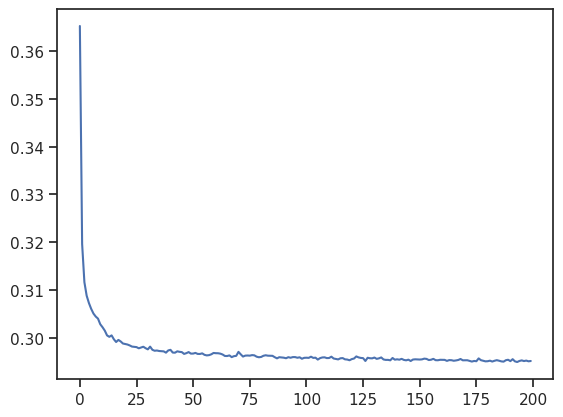

In [4]:
# WAE.py

from HEA_COGS.Functions import imq_kernel, weights_init


#%%train the WAE
model = WAE(raw_x.shape[1]).to(device) # initialize the model 
optimizer = Adam(model.parameters(), lr = params['lr'], weight_decay = params['weight_decay']) # optimizer
def train_WAE(model, optimizer, dataloader, params):
    model_name = params['model_name']
    num_epoch = params['num_epoch']
    sigma = params['sigma'] # assuming the latent space follows Gaussian
    MMD_lambda = params['MMD_lambda'] #WAE distance (maximum mean discrepancy)

    folder_dir = os.path.join(root, model_name) # a folder to save models
    if not os.path.isdir(folder_dir):
        os.mkdir(folder_dir)
    loss_=[]   
    for epoch in range(num_epoch):
        start_time = time.time()
        total_loss = [] #save for plot, recon loss+MMD
        total_recon = [] # binary cross entropy
        total_MMD = [] #maximum mean discrepancy
        
        for i, data in enumerate(dataloader):
            x = data[0].to(device)
            y = data[1].to(device)
            model.train() # model goes to train mode
            recon_x, z_tilde = model(x) # latent space is Z_tilde
            z = sigma*torch.randn(z_tilde.size()).to(device) # z is sampled from a Gaussian that has the same dimension (but no relation to z_tilde).

            recon_loss = F.binary_cross_entropy(recon_x, x, reduction='mean') #lowest reconstruction loss 
            #recon_loss = F.mse_loss(recon_x, x, reduction='mean') 
            #recon_loss = F.l1_loss(recon_x, x, reduction='mean')
            
            MMD_loss = imq_kernel(z_tilde, z, h_dim=2, device=device).to(device) #W-distance between z_tilde and z
            MMD_loss = MMD_loss / x.size(0) #averaging, because recon loss is mean.
            loss = recon_loss + MMD_loss * MMD_lambda #MM_lambda: learning-rate alike, hyperparamer

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss.append(loss.item())# from tensor to values
            total_recon.append(recon_loss.item())
            total_MMD.append(MMD_loss.item())

        avg_loss = sum(total_loss)/len(total_loss)
        avg_recon = sum(total_recon)/len(total_recon)
        avg_MMD = sum(total_MMD)/len(total_MMD)
        loss_.append(avg_loss)

        #scheduler.step(avg_loss)

        print('[{:03}/{:03}] loss: {:.6f} Recon_loss: {:.6f}, MMD_loss:{:.6f}, time: {:.3f} sec'.format(\
                                        epoch+1, num_epoch, \
                                        avg_loss, \
                                        avg_recon, avg_MMD, time.time() - start_time))
        # save the model every 5 epoches
        if (epoch+1) % 5 == 0:
            save_model_dir = str(model_name + "_{}.pth".format(epoch+1))
            torch.save(model.state_dict(), os.path.join(folder_dir, save_model_dir))
    return loss_

loss_=train_WAE(model, optimizer, dataloader, params)
plt.figure()
sns.set_style('ticks')
plt.plot(range(len(loss_)),loss_)
#%%Double check on the reconstructed compositions
#one way to find out whether WAE (or any other VAE) has learned the repsentation is 
# to compare the reconstructed and original compositions.if you are not happy with the 
# reconstruction. go back to the previous step and change the params.
#double check on the recontructed compositions
#t = time.localtime()
model_dir = os.path.join(root,'{}/{}_{}.pth'.format(params['model_name'], params['model_name'],params['num_epoch']))#load your model
model = WAE(raw_x.shape[1]).to(device)
model.load_state_dict(torch.load(model_dir))
model.eval()
with torch.no_grad():
    test = torch.FloatTensor(raw_x).to(device)
    recon_x, z = model(test)
    recon_x = model.decoder(z)
    recon_x = recon_x.cpu().detach().numpy()

column_name = ['Fe','Ni','Co','Cr','V','Cu']#,'VEC','AR1','AR2','PE','Density','TC','MP','FI','SI','TI','M']
#recon_x = (recon_x * (max-min)) + min
pd.DataFrame(recon_x.round(3), columns=column_name).loc[690:695]
#csv_data = pd.read_csv('data_base.csv', header=0).iloc[:,1:19]
csv_data = pd.read_csv(csv_file_path, header=0).iloc[:,1:19]
csv_data.iloc[690:702,:6].round(3)



/tmp/ipykernel_4018824/493705125.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_dir))


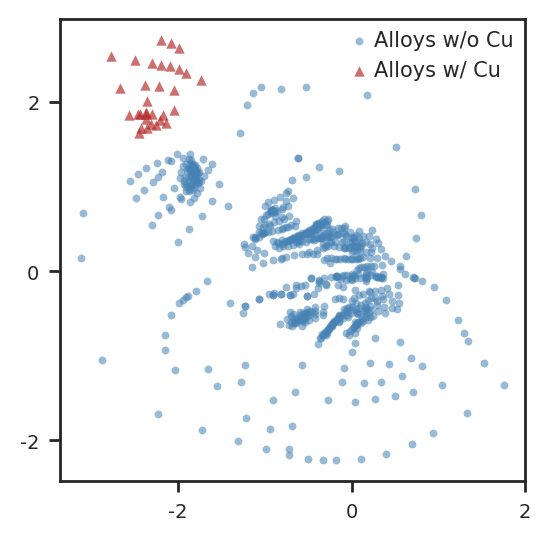

In [5]:
# WAE.py

from HEA_COGS.Functions import get_latents

#%%Visualize the WAE latent space
# Here we assign different colors to alloy with and without Copper, as we expected them to differ significantly in the latent space.
sns.set_style('ticks')
model = WAE(raw_x.shape[1]).to(device)
model.load_state_dict(torch.load(model_dir))
dataset = FeatureDataset(raw_x[:], raw_y[:])
latents = get_latents(model, dataset, device=device)

low_cu = raw_x[:,5] < 0.05
low_cu_latent = latents[low_cu]
low_cu_color = raw_y[:][low_cu]

high_cu = raw_x[:,5] >= 0.05
high_cu_latent = latents[high_cu]
high_cu_color = raw_y[:][high_cu]


# figure settings
fig, axs = plt.subplots(figsize = (3, 3),dpi=200)

#axs.set_aspect(1.)
#axs.set_ylim(-7,7)
#axs.set_xlim(-11,5)

axs.set_yticks(np.arange(-6, 8, step=2))
axs.set_xticks(np.arange(-10, 5, step=2))

axs.set_yticklabels(np.arange(-6, 8, step=2), fontsize=7)
axs.set_xticklabels(np.arange(-10, 5, step=2), fontsize=7)


for axis in ['top','bottom','left','right']:
  axs.spines[axis].set_linewidth(1.)


axs.tick_params(axis='both', which='major', top=False, labeltop=False, direction='out', width=1., length=4)
axs.tick_params(axis='both', which='major', right=False, labelright=False, direction='out', width=1., length=4)

#scatter1 = axs.scatter(low_cu_latent[:,0], low_cu_latent[:,1], c=low_cu_color, alpha=.75, s=10, linewidths=0, cmap='viridis')
#scatter2 = axs.scatter(high_cu_latent[:,0], high_cu_latent[:,1], c=high_cu_color, alpha=.75, s=9, linewidths=0, cmap='Reds')

scatter1 = axs.scatter(low_cu_latent[:,0], low_cu_latent[:,1], c='steelblue', alpha=.55, s=8, linewidths=0, label='Alloys w/o Cu')
scatter2 = axs.scatter(high_cu_latent[:,0], high_cu_latent[:,1], c='firebrick', alpha=.65, s=14, linewidths=0, marker='^', label='Alloys w/ Cu')
#scatter3 = axs.scatter(latents_exp_4[:,0], latents_exp_4[:,1], alpha=1., s=10, linewidths=.75, edgecolors='darkslategray', facecolors='w')#, label='New FeCoNiCr HEAs')
#scatter4 = axs.scatter(latents_exp_5[:,0], latents_exp_5[:,1], alpha=1., s=16, linewidths=.75, edgecolors='darkred', facecolors='w',marker='^')#, label='New FeCoNiCrCu HEAs')

handles,labels = axs.get_legend_handles_labels()
handles = handles[::1]
labels = labels[::1]

legend_properties = {'size':7.5}
axs.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.015,1.017), handletextpad=-0.3, frameon=False, prop=legend_properties)
#axs.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.045,1.017), handletextpad=-0.3, frameon=False, prop=legend_properties)

#rect = patches.Rectangle((-19.4,15.0), 18, 4.5, linewidth=0,edgecolor=None,facecolor='k', alpha=0.03,linestyle=None,zorder=-10) #(0.2,15.4), 14, 4.1
#axs.add_patch(rect)

fig.savefig('Figure3_a.tif', bbox_inches = 'tight', pad_inches=0.01)

Average negative log likelihood: 1.8492911377789336
1
Average negative log likelihood: 2.2827011636916916
2
Average negative log likelihood: 2.118099878341975
3
Average negative log likelihood: 2.015949370989386
4
Average negative log likelihood: 1.8492911377789336
5
Average negative log likelihood: 1.8696647842711183
6
Average negative log likelihood: 1.8900428519371502
7
Average negative log likelihood: 1.8080084857046956


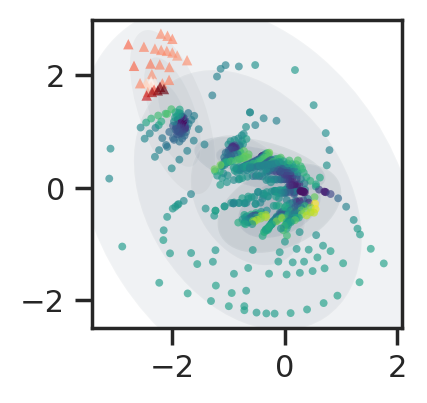

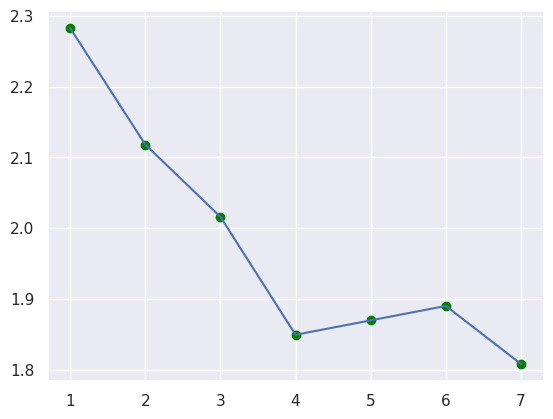

In [6]:
# GMM.py
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 25 18:31:05 2022

@author: Po-Yen Tung; Ziyuan Rao
"""


import cv2
import os
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from HEA_COGS.Functions import plot_gmm

# 首先，导入 HEA_COGS 模块，确保 HEA_COGS 在命名空间中可用。
#import HEA_COGS.Functions
# 然后，重新加载 HEA_COGS.Functions 模块
#importlib.reload(HEA_COGS.Functions)

# Here the GMM is applied, you might wonder why 4 is chosen, the answer can be found below
gm = GaussianMixture(n_components=4, random_state=0, init_params='kmeans').fit(latents) #plot a n_components v.s. Average negative log likelihood
print('Average negative log likelihood:', -1*gm.score(latents))
plot_gmm(gm, latents, raw_x, raw_y)  # 传递 raw_x 和 raw_y 作为参数

# Using elbow method to find out the best # of components, the lower the negative log likehood the better the model is, but too many cluster is trivial. just imagine you fit each individual data points with a Gaussian, in this case, you would have a very good model. but the such fitting is not very useful.

# In this case, the best number of cluster is either 4 or 5.

scores=[] #using elbow method to find out the best # of components
for i in range(1,8):
  print(i)
  gm = GaussianMixture(n_components=i, random_state=0, init_params='kmeans').fit(latents)
  print('Average negative log likelihood:', -1*gm.score(latents))
  scores.append(-1*gm.score(latents))
  
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.figure()
plt.scatter(range(1,8), scores,color='green')
plt.plot(range(1,8),scores)
plt.savefig('elbow_plot.png', format='png', dpi=300)
plt.show()


[1/5] train_acc: 0.8237 || test_acc: 0.8857
[2/5] train_acc: 0.8779 || test_acc: 0.7122
[3/5] train_acc: 0.8061 || test_acc: 0.9065
[4/5] train_acc: 0.8492 || test_acc: 0.8058
[5/5] train_acc: 0.8241 || test_acc: 0.9137
train_acc: 0.8362 || test_acc: 0.8448


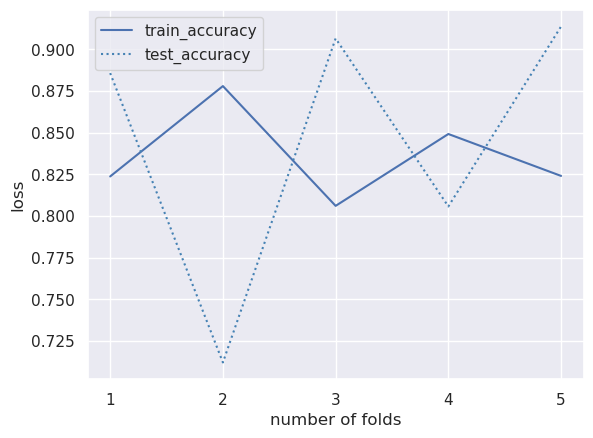

In [7]:
# INVAR Classifier.py
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 25 18:33:41 2022

@author: Po-Yen Tung; Ziyuan Rao
"""
import cv2
import os
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from HEA_COGS.Functions import AttributeDataset

# A simple neural network classifier that predicts INVAR based on composition.
class Classifier(nn.Module): #a very simple classifer with large dropout. intuition here: as simple as possible, given that we only have 2d input
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2,8),
            nn.Dropout(0.5),
            nn.Linear(8,1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.fc(x)

#%%Classifier training, Again you can play around with params just to see how it affects the model accuracy (training and tesing)

from matplotlib.pyplot import MultipleLocator
same_seeds(1)

params['cls_bs'] = 16
params['cls_lr'] = 1e-4
params['cls_epoch'] = 100
params['num_fold'] = 5


params['label_y'] = np.where(raw_y<5, 1, 0)
params['latents'] = latents

cls = Classifier().to(device)
opt = Adam(cls.parameters(), lr=params['cls_lr'], weight_decay=0.)


def training_Cls(model, optimizer, params):
    label_y = params['label_y']
    latents = params['latents']
    cls_epoch = params['cls_epoch']

    kf = KFold(n_splits=params['num_fold'])
    train_acc = []
    test_acc = []

    k=1
    for train, test in kf.split(latents):
        x_train, x_test, y_train, y_test = latents[train], latents[test], label_y[train], label_y[test]
        cls_dataset = AttributeDataset(x_train, y_train)
        cls_dataloader = DataLoader(cls_dataset, batch_size=params['cls_bs'], shuffle=True)
        cls_testDataset = AttributeDataset(x_test, y_test)
        cls_testDataloader = DataLoader(cls_testDataset, batch_size=cls_testDataset.__len__(), shuffle=False)


        for epoch in range(cls_epoch):
            t = time.time()
            total_loss = []
            total_acc = []
            cls.train()
            
            for i, data in enumerate(cls_dataloader):
                x = data[0].to(device)
                y = data[1].to(device)
                y_pred = cls(x)
                loss = F.binary_cross_entropy(y_pred, y)
                total_acc.append(torch.sum(torch.where(y_pred>=0.5,1,0) == y).detach().cpu().numpy())
                total_loss.append(loss.item())

                opt.zero_grad()
                loss.backward()
                opt.step()
            
            #eval
            cls.eval()
            for test in cls_testDataloader:
                x = test[0].to(device)
                y = test[1].to(device)
                y_pred = cls(x)
                accuracy = torch.sum(torch.where(y_pred>=0.5,1,0) == y) / y_pred.size(0)
                test_loss = F.binary_cross_entropy(y_pred, y)

            #print(f'[{epoch+1:03}/{cls_epoch}] loss:{sum(total_loss)/len(total_loss):.3f} test_loss:{test_loss.item():.3f} acc:{sum(total_acc)/cls_dataset.__len__():.3f} test_acc:{accuracy:.3f} time:{time.time()-t:.3f}')
        
        print('[{}/{}] train_acc: {:.04f} || test_acc: {:.04f}'.format(k, params['num_fold'], sum(total_acc)/cls_dataset.__len__(), accuracy.item()))
        train_acc.append(sum(total_acc)/cls_dataset.__len__())
        test_acc.append(accuracy.item())
        k+=1
    print('train_acc: {:.04f} || test_acc: {:.04f}'.format(sum(train_acc)/len(train_acc), sum(test_acc)/len(test_acc)))
    plt.figure()
    sns.set_style()
    plt.xlabel('number of folds')
    plt.ylabel('loss')
    x=range(1,params['num_fold']+1)
    sns.set_style("darkgrid")
    x_major_locator=MultipleLocator(1)
    ax=plt.gca()
    plt.plot(x, train_acc)
    plt.plot(x, test_acc, linestyle=':', c='steelblue')
    plt.legend(["train_accuracy", "test_accuracy"])
    ax.xaxis.set_major_locator(x_major_locator)
    plt.savefig('figure/binary_classifier.png',dpi=300)
    return train_acc, test_acc

train_acc, test_acc = training_Cls(cls, opt, params)


In [8]:
# MCMC Sampling.py
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 27 15:29:52 2022

@author: Po-Yen Tung; Ziyuan Rao
"""


import cv2
import os
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

def MCMC(gm, classifier, n_samples, sigma=0.1): #MCMC
    sample_z = []

    z = gm.sample(1)[0]
    for i in range(n_samples):
        uniform_rand = np.random.uniform(size=1)
        z_next = np.random.multivariate_normal(z.squeeze(),sigma*np.eye(2)).reshape(1,-1)

        z_combined = np.concatenate((z, z_next),axis=0)
        scores = cls(torch.Tensor(z_combined).to(device)).detach().cpu().numpy().squeeze() 
        z_score, z_next_score = np.log(scores[0]), np.log(scores[1]) #z score needes to be converted to log, coz gm score is log.
        z_prob, z_next_prob = (gm.score(z)+z_score), (gm.score(z_next)+z_next_score) # two log addition, output: log probability
        accepence = min(0, (z_next_prob - z_prob))

        if i == 0:
            sample_z.append(z.squeeze())

        if np.log(uniform_rand) < accepence:
            sample_z.append(z_next.squeeze())
            z = z_next
        else:
            pass

    return np.stack(sample_z)

#%%Sample 5000 times with sigma=0.5
sample_z = MCMC(gm=gm, classifier=cls, n_samples=5000, sigma=0.5)
WAE_comps = model._decode(torch.Tensor(sample_z).to(device)).detach().cpu().numpy()  # new_comps save as csv and goes to TERM
print('Sample size:', sample_z.shape)   
WAE_comps=pd.DataFrame(WAE_comps)
WAE_comps.columns=column_name
WAE_comps.to_csv('comps_WAE.csv',index=False)
WAE_comps.head() 


Sample size: (1688, 2)


,Fe,Ni,Co,Cr,V,Cu
0,0.645188,0.354281,0.000028,0.000204,0.000294,4.716625e-06
1,0.565116,0.297925,0.094890,0.000009,0.042059,1.012891e-06
2,0.387703,0.261403,0.264386,0.000002,0.086505,2.538065e-06
3,0.381533,0.171714,0.429187,0.017561,0.000006,3.664384e-08
4,0.340130,0.082388,0.508012,0.000003,0.069464,2.327119e-06


In [9]:
# Gradient boosting decision tree.py
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 27 15:40:00 2022

@author: z.rao
"""


import os
import time
from bayes_opt import BayesianOptimization
#from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import numpy as np
#import seaborn as sns
#from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import explained_variance_score
#from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import datetime
import pandas as pd


from TERM.Ultility_functions import normalizing_data


starttime = datetime.datetime.now()

t = time.localtime()
model_name = 'Invar_inference_GBDT'
file_name = '{}.xlsx'.format(model_name)
#data = pd.read_csv('data_base.csv')
data = pd.read_csv('/home/Huyy/workspace/code/component_zj/HighEntropyAlloy/HighEntropyAlloy_zj/project/data/data_base.csv')
train_features, test_features, train_labels, test_labels = normalizing_data(data,seed=42)
train_features, test_features = train_features.cpu().data.numpy(),test_features.cpu().data.numpy()
train_labels, test_labels = train_labels.cpu().data.numpy(), test_labels.cpu().data.numpy()
train_labels, test_labels = train_labels.reshape(-1), test_labels.reshape(-1) 
#define the model
def train_model(num_leaves,
                min_child_samples,
            learning_rate,
            n_estimators, 
            max_bin,
            colsample_bytree, 
            subsample, 
            max_depth, 
            reg_alpha,
            reg_lambda,
            min_split_gain,
            min_child_weight
            ):
    params = {
        "num_leaves": int(round(num_leaves)),
        'min_child_samples':int(round(min_child_samples)),
        'learning_rate': learning_rate,
        'n_estimators': int(round(n_estimators)),
        'max_bin': int(round(max_bin)),
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'subsample': max(min(subsample, 1), 0),
        'max_depth': int(round(max_depth)),
        'reg_alpha':  max(reg_alpha, 0),
        'reg_lambda': max(reg_lambda, 0),
        'min_split_gain': min_split_gain,
        'min_child_weight': min_child_weight,
        'verbose': -1
                  }
    model = LGBMRegressor(**params)
    model.fit(train_features, train_labels)
    y_pred = model.predict(test_features)
    error = -np.mean(np.abs((test_labels - y_pred) / test_labels))       # print(error)     
    return error
#define the parameters for optimize
bounds = {'num_leaves': (5, 60),#50
          'min_child_samples':(1, 50),
          'learning_rate': (0.001, 1),
          'n_estimators': (5, 200),#100
            'max_bin': (5, 100),#10
          'colsample_bytree': (0.5, 1),
          'subsample': (0.1, 2),
          'max_depth': (1, 60),#10
          'reg_alpha': (0.01, 1), #5
          'reg_lambda': (0.01, 1),#5
          'min_split_gain': (0.001, 0.1),
          'min_child_weight': (0.0001, 30)}
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=bounds,
    random_state=1,
)
#optimize the parameter with BO
optimizer.maximize(init_points = 10, n_iter=1)
#save the results
table = pd.DataFrame(columns=['target', 'colsample_bytree', 'learning_rate', 'max_bin',
                      'max_depth','min_child_samples','min_child_weight','min_split_gain',
                      'n_estimators','num_leaves','reg_alpha','reg_lambda','subsample'])
for res in optimizer.res:
    #Replace all instances of table.append() with pd.concat()
    table=pd.concat([
        table,
        pd.DataFrame({'target':[res['target']],'colsample_bytree':[res['params']['colsample_bytree']],
                                     'colsample_bytree':[res['params']['colsample_bytree']],
                                     'learning_rate':[res['params']['learning_rate']],
                                     'max_bin':[res['params']['max_bin']],
                                     'max_depth':[res['params']['max_depth']],
                                     'min_child_samples':[res['params']['min_child_samples']],
                                     'min_child_weight':[res['params']['min_child_weight']],
                                     'min_split_gain':[res['params']['min_split_gain']],
                                     'n_estimators':[res['params']['n_estimators']],
                                     'num_leaves':[res['params']['num_leaves']],
                                     'reg_alpha':[res['params']['reg_alpha']],
                                     'reg_lambda':[res['params']['reg_lambda']],
                                     'subsample':[res['params']['subsample']]})
                                     ],
                                     ignore_index=True)
table=pd.concat([
    table,
    pd.DataFrame({'target':[optimizer.max['target']],'colsample_bytree':[optimizer.max['params']['colsample_bytree']],
                                 'colsample_bytree':[optimizer.max['params']['colsample_bytree']],
                                 'learning_rate':[optimizer.max['params']['learning_rate']],
                                 'max_bin':[optimizer.max['params']['max_bin']],
                                 'max_depth':[optimizer.max['params']['max_depth']],
                                 'min_child_samples':[optimizer.max['params']['min_child_samples']],
                                 'min_child_weight':[optimizer.max['params']['min_child_weight']],
                                 'min_split_gain':[optimizer.max['params']['min_split_gain']],
                                 'n_estimators':[optimizer.max['params']['n_estimators']],
                                 'num_leaves':[optimizer.max['params']['num_leaves']],
                                 'reg_alpha':[optimizer.max['params']['reg_alpha']],
                                 'reg_lambda':[optimizer.max['params']['reg_lambda']],
                                 'subsample':[optimizer.max['params']['subsample']]})
                                    ],
                                 ignore_index=True)
table.to_excel(file_name)
endtime = datetime.datetime.now()
print ('running time {}'.format(endtime - starttime))

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | min_sp... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | -0.2677   | 0.7085    | 0.7206    | 5.011     | 18.84     | 8.191     | 2.77      | 0.01944   | 72.38     | 26.82     | 0.5434    | 0.425     | 1.402     |
| 2         | -0.2826   | 0.6022    | 0.8782    | 7.602     | 40.56     | 21.45     | 16.76     | 0.0149    | 43.63     | 49.04     | 0.9686    | 0.3203    | 1.415     |
| 3         | -0.316    | 0.9382    | 0.8947    | 13.08     | 3.304     | 9.322     | 26.34     | 0.01074   | 87.12     | 57.68     | 0.5378    | 0.695     | 0.6995    |
| 4         | -0.2509   | 0.8433    | 0.8348    | 6.737     | 45.26     | 49.45     | 22.44     | 0.02876   | 158.9     | 10.68     | 0.4534    | 0.90

/home/Huyy/miniconda3/envs/component/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/Huyy/miniconda3/envs/component/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/Huyy/miniconda3/envs/component/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/Huyy/miniconda3/envs/component/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/Huyy/miniconda3/envs/component/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force

| 8         | -0.2212   | 0.635     | 0.896     | 45.67     | 57.93     | 33.51     | 18.65     | 0.01236   | 190.2     | 29.75     | 0.5826    | 0.4141    | 0.5504    |
| 9         | -0.3106   | 0.9517    | 0.5741    | 5.273     | 37.41     | 17.01     | 15.81     | 0.08871   | 74.67     | 54.97     | 0.6271    | 0.02566   | 1.866     |
| 10        | -0.2669   | 0.8454    | 0.9973    | 21.37     | 9.091     | 46.7      | 20.9      | 0.007534  | 152.3     | 46.46     | 0.9238    | 0.7144    | 0.3361    |


/home/Huyy/miniconda3/envs/component/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/Huyy/miniconda3/envs/component/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/Huyy/miniconda3/envs/component/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/Huyy/miniconda3/envs/component/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/Huyy/miniconda3/envs/component/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force

| 11        | -0.4374   | 0.5615    | 0.02967   | 40.1      | 12.54     | 42.23     | 8.284     | 0.01945   | 139.5     | 57.4      | 0.03863   | 0.9311    | 0.7869    |
running time 0:00:00.522711


In [10]:
# Neural network architecture.py
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 27 15:37:02 2022

@author: z.rao
"""
import datetime
import torch.utils.data as Data
import pandas as pd
import torch
import torch.nn.functional as F    
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from bayes_opt import BayesianOptimization
import time
import os
from sklearn import preprocessing

from TERM.Ultility_functions import normalizing_data

# 使用自定义的 MAPELoss
import torch
import torch.nn as nn

class MAPELoss(nn.Module):
    def __init__(self):
        super(MAPELoss, self).__init__()

    def forward(self, y_pred, y_true):
        """
        Calculates the Mean Absolute Percentage Error (MAPE) loss.

        Args:
            y_pred (torch.Tensor): Predicted values.
            y_true (torch.Tensor): True values.

        Returns:
            torch.Tensor: MAPE loss.
        """
        return torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100

#build the model
class Net(nn.Module):  
    def __init__(self, n_feature=17, n_hidden=218, n_output=1, w = 6):
        super(Net, self).__init__()    
        # self.BN=torch.nn.BatchNorm1d(n_hidden)
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden) 
        nn.init.kaiming_normal_(self.hidden1.weight)
        
        self.hiddens = nn.ModuleList ([nn.Linear(n_hidden, n_hidden) for i in range(w)])                            
        for m in self.hiddens:
            nn.init.kaiming_normal_(m.weight)   
        
        self.predict = torch.nn.Linear(n_hidden, n_output)  
        nn.init.kaiming_normal_(self.predict.weight)

    def forward(self, x):  
        x = self.hidden1(x)
        # x = self.BN(x)
        # x = self.Dropout (x)
        x = F.relu(x)   
        
        for m in self.hiddens:
            x = m(x)
            # x = self.BN(x)
            x = F.relu(x) 
                      
        x = self.predict(x)
        # x = self.BN_3(x)
        # x = self.Dropout (x)
          # 输出值
        return x
#set the parameters for training
def train(net, num_epochs, batch_size, train_features, test_features, train_labels, test_labels,
          train_loader,
          optimizer):
    print ("\n=== train begin ===")
    print(net)
    train_ls, test_ls = [], []
    loss = MAPELoss() # MAPE means Mean Absolute percentile error 
    for epoch in range(num_epochs):
        for x, y in train_loader:
            ls = loss(net(x).view(-1, 1), y.view(-1, 1))
            optimizer.zero_grad()
            ls.backward()
            optimizer.step()
        if epoch % 100 == 0:
            train_ls.append(loss(net(train_features).view(-1, 1), train_labels.view(-1, 1)).item())
            test_ls.append(loss(net(test_features).view(-1, 1), test_labels.view(-1, 1)).item())
            print ("epoch %d: train loss %f, test loss %f" % (epoch, train_ls[-1], test_ls[-1]))
        
    print ("=== train end ===")
#set the parameters for testing    
def test(model, test_loader):
    model.eval()
    test_loss = 0
    n = 0
    loss = MAPELoss() 
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss(output.view(-1, 1), target.view(-1, 1)).item()  # sum up batch loss
            n += 1

    test_loss /= n
    
    print('Test set: Average loss: {:.4f}'.format(
        test_loss))
    
    return test_loss   

#train the data
def train_model(batch_size,lr, module__n_hidden,module__w):
    module__n_hidden = int(module__n_hidden) # number of neurons per layer
    module__w = int(module__w) # number of hidden layers
    batch_size = int(batch_size)
    train_dataset = Data.TensorDataset(train_features, train_labels)
    test_dataset = Data.TensorDataset(test_features, test_labels)
    train_loader = Data.DataLoader(train_dataset, batch_size, shuffle=True)
    test_loader = Data.DataLoader(test_dataset, batch_size, shuffle=True) 
    net = Net(n_feature=17, n_hidden=module__n_hidden, n_output=1, w = module__w)
    if torch.cuda.is_available():
      net = net.cuda()
    n_epochs = 20 
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.0001)
    train(net, n_epochs, batch_size,train_features, test_features, 
          train_labels, test_labels,train_loader, optimizer)
    train_loss= test(net,train_loader)
    test_loss = test(net, test_loader)

    
    r = -np.abs(train_loss-test_loss)
    
    return -test_loss
#build the ensemble traning for NN
import datetime
import torch.utils.data as Data
import pandas as pd
import torch
import torch.nn.functional as F   
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import time
import os
import pickle 
import seaborn as sns
t = time.localtime() 
plt.close('all')
#target = pd.read_excel('BO/05-18-19-09-Invar_NN_BO(10+100).xlsx')
target = pd.read_excel('/home/Huyy/workspace/code/component_zj/HighEntropyAlloy/HighEntropyAlloy_zj/project/notebooks/Invar_inference_NN.xlsx')
starttime = datetime.datetime.now()
#for i in range(7,8): # This is to choose best 10 points 
#    for j in range(42,44): # 10 different seeds
for i in range(9,11):
    for j in range(40,45):

        # 20250402yayun 检查模型是否已经训练完成
        if os.path.exists('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(i,j)):
            print('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt already trained'.format(i,j))
            continue

        train_features, test_features, train_labels, test_labels = normalizing_data(data, seed=j)
        #lr = target.at[i,'lr'] # the same
        #module__n_hidden = target.at[i,'module__n_hidden']
        #module__w = target.at[i,'module__w']
        #batch_size = target.at[i,'batch_size']
        
        #module__n_hidden = int(module__n_hidden)
        #module__w = int(module__w)
        #batch_size = int(batch_size)
        #print (module__w)
        
        batch_size = target.at[i,'batch_size'] # choose 'batch_size' paramter at ith row
        lr = target.at[i,'lr'] # the same
        module__n_hidden = target.at[i,'module__n_hidden']
        module__w = target.at[i,'module__w']
        
        module__n_hidden = int(module__n_hidden)
        module__w = int(module__w)
        batch_size = int(batch_size)
        print (module__w)
        train_dataset = Data.TensorDataset(train_features, train_labels)
        test_dataset = Data.TensorDataset(test_features, test_labels)
        train_loader = Data.DataLoader(train_dataset, batch_size, shuffle=True)
        test_loader = Data.DataLoader(test_dataset, batch_size, shuffle=True) 
            

        class Net(nn.Module):  
            def __init__(self, n_feature=17, n_hidden=module__n_hidden, n_output=1, w = module__w):
                super(Net, self).__init__()   
                # self.BN=torch.nn.BatchNorm1d(n_hidden)
                self.hidden1 = torch.nn.Linear(n_feature, n_hidden) 
                nn.init.kaiming_normal_(self.hidden1.weight)
                
                self.hiddens = nn.ModuleList ([nn.Linear(n_hidden, n_hidden) for i in range(w)])                            
                for m in self.hiddens:
                    nn.init.kaiming_normal_(m.weight)   
                
                self.predict = torch.nn.Linear(n_hidden, n_output) 
                nn.init.kaiming_normal_(self.predict.weight)
        
            def forward(self, x): 
                x = self.hidden1(x)
                # x = self.BN(x)
                # x = self.Dropout (x)
                x = F.relu(x)   
                
                for m in self.hiddens:
                    x = m(x)
                    # x = self.BN(x)
                    x = F.relu(x) 
                              
                x = self.predict(x)
                # x = self.BN_3(x)
                # x = self.Dropout (x)
                return x
   
        def plotCurve(x_vals, y_vals, 
                        x_label, y_label, 
                        x2_vals=None, y2_vals=None, 
                        legend=None,
                        figsize=(3.5, 2.5)):
            # set figsize
            plt.xlabel(x_label)
            plt.ylabel(y_label)
            plt.plot(x_vals, y_vals)
            if x2_vals and y2_vals:
                plt.plot(x2_vals, y2_vals, linestyle=':')
            
            if legend:
                plt.legend(legend)
        #training 
        print ("\n=== train begin ===")
        
        net = Net()
        print(net)
        if torch.cuda.is_available():
            net = net.cuda()    
        train_ls, test_ls = [], []
        loss = MAPELoss() 
        n_epochs = 3000
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.0001)
        for epoch in range(n_epochs):
            for x, y in train_loader:
                ls = loss(net(x).view(-1, 1), y.view(-1, 1))
                optimizer.zero_grad()
                ls.backward()
                optimizer.step()
            train_ls.append(loss(net(train_features).view(-1, 1), train_labels.view(-1, 1)).item())
            test_ls.append(loss(net(test_features).view(-1, 1), test_labels.view(-1, 1)).item())
            if epoch % 100 == 0:
                print ("epoch %d: train loss %f, test loss %f" % (epoch, train_ls[-1], test_ls[-1]))
        print ("plot curves")
        plotCurve(range(1, n_epochs + 1), train_ls,"epoch", "loss",range(1, n_epochs + 1), test_ls,["train", "test"])
        plt.text(60, 0.7, 'Loss=%.4f' % test_ls[-1], fontdict={'size': 20, 'color':  'red'})
        folder_dir = 'Results/Invar_NN_BO(10+100)_6'
        if not os.path.isdir(folder_dir):
          os.mkdir(folder_dir)
        folder_dir = 'Results/Invar_NN_BO(10+100)_6/Figures'
        if not os.path.isdir(folder_dir):
          os.mkdir(folder_dir)
        fig_name_1 = 'Results/Invar_NN_BO(10+100)_6/Figures/{}-seed_{}_1.png'.format(i,j)
        plt.savefig(fig_name_1, format='png', dpi=300)            
                   
        #plotting
        net.eval()
        predict=net(test_features)
        predict=predict.cpu()
        predict=predict.data.numpy()  
        plt.figure()
        sns.regplot(x=predict, y=test_labels.cpu().data.numpy(), color='g') 
        fig_name_2 = 'Results/Invar_NN_BO(10+100)_6/Figures/{}-seed_{}.png'.format(i,j)
        plt.savefig(fig_name_2, format='png', dpi=300)
         
        #save the models
        net_name = 'Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(i,j)
        torch.save(net.state_dict(), net_name)
        
endtime = datetime.datetime.now()
Rtime = endtime - starttime
print(Rtime)


Results/Invar_NN_BO(10+100)_6/9-seed_40.pt already trained
Results/Invar_NN_BO(10+100)_6/9-seed_41.pt already trained
Results/Invar_NN_BO(10+100)_6/9-seed_42.pt already trained
Results/Invar_NN_BO(10+100)_6/9-seed_43.pt already trained
Results/Invar_NN_BO(10+100)_6/9-seed_44.pt already trained
Results/Invar_NN_BO(10+100)_6/10-seed_40.pt already trained
Results/Invar_NN_BO(10+100)_6/10-seed_41.pt already trained
Results/Invar_NN_BO(10+100)_6/10-seed_42.pt already trained
Results/Invar_NN_BO(10+100)_6/10-seed_43.pt already trained
Results/Invar_NN_BO(10+100)_6/10-seed_44.pt already trained
0:00:00.001376


In [11]:
# Ensemble model_stage_1.py
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 27 15:41:22 2022

@author: z.rao
"""

import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
import datetime
import torch.utils.data as Data
import pandas as pd
import torch
import torch.nn.functional as F     # 激励函数都在这
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
#from My_Modules import MAPELoss
from bayes_opt import BayesianOptimization
import time
import os
import pickle 
import seaborn as sns

#提取数据
plt.close('all')
#data = pd.read_excel('Data_base_DFT_Thermal.xlsx')
data = pd.read_excel('/home/Huyy/workspace/code/component_zj/HighEntropyAlloy/HighEntropyAlloy_zj/project/data/Data_base.xlsx')
df_all = data.drop(columns=['alloy'])
#第一轮_成分_总集
First_round_Comp_total = pd.DataFrame()
#选择列：[[列名列表]]
x1 = df_all [['Fe','Ni','Co','Cr','V','Cu','VEC','AR1','AR2','PE','Density','TermalC','MP','FI','SI','TI','M']]
# X = x1
X = x1[0:696]
# for later predictions
Comp = x1[696:714]
#Comp=Comp.rename({696:0,697:1,698:2,699:3,700:4,701:5,702:6,703:7,704:8,705:9,706:10,707:11,708:12,
#                   709:13,710:14,711:15,712:16,713:17,714:18,715:19,716:20,717:21,718:22},axis=0)
# 将 Comp 写入到 '1_round_candidates.xlsx' 文件中
Comp.to_excel('1_round_candidates.xlsx', index=False)

y1 = df_all [['TEC']]
# y1 = y1[0:705]
Y = y1[0:696]
# bins     = [18,35,48,109,202,234,525,687,695]
bins     = [18,35,48,109,202,234,525,687]
y_binned = np.digitize(Y.index, bins, right=True)



# 使用自定义的 MAPELoss
import torch
import torch.nn as nn

class MAPELoss(nn.Module):
    def __init__(self):
        super(MAPELoss, self).__init__()
    """
    Calculates the Mean Absolute Percentage Error (MAPE) loss.

    Args:
        y_pred (torch.Tensor): Predicted values.
        y_true (torch.Tensor): True values.

    Returns:
        torch.Tensor: MAPE loss.
    """
    def forward(self, y_pred, y_true):
        return torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100




def Tree(n,seed):
    """
    Trains a GBDT (Gradient Boosting Decision Tree) regression model and returns predictions for candidate alloy compositions.

    Parameters:
    - i: Row index in the hyperparameter file, used to select a specific set of hyperparameters
    - j: Random seed, used to control the randomness of data splitting

    Returns:
    - prediction: Predictions for the candidate alloy compositions, typically an array of predicted values

    Functionality:
    1. Reads GBDT model parameters from the hyperparameter file
    2. Initializes a GBDT model using these parameters
    3. Trains the model and makes predictions for the candidate alloy compositions

    Use Case:
    In an ensemble learning framework, this function is used to generate predictions from multiple GBDT models, which are then combined to improve prediction accuracy and stability.
    """
    #提取你需要的参数
    #target = pd.read_excel('BO/05-18-12-09-Invar_GBDT(50+500).xlsx')
    target = pd.read_excel('/home/Huyy/workspace/code/component_zj/HighEntropyAlloy/HighEntropyAlloy_zj/project/notebooks/Invar_inference_GBDT.xlsx')
    colsample_bytree = target.at[n,'colsample_bytree']
    learning_rate = target.at[n,'learning_rate']
    max_bin = target.at[n,'max_bin']
    max_depth = target.at[n,'max_depth']
    max_bin = target.at[n,'max_bin']
    min_child_samples = target.at[n,'min_child_samples']
    min_child_weight = target.at[n,'min_child_weight']
    min_split_gain= target.at[n,'min_split_gain']
    n_estimators = target.at[n,'n_estimators']
    num_leaves = target.at[n,'num_leaves']
    reg_alpha = target.at[n,'reg_alpha']
    reg_lambda = target.at[n,'reg_lambda']
    subsample = target.at[n,'subsample']
    params = {
        "num_leaves": int(round(num_leaves)),
        'min_child_samples':int(round(min_child_samples)),
        'learning_rate': learning_rate,
        'n_estimators': int(round(n_estimators)),
        'max_bin': int(round(max_bin)),
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'subsample': max(min(subsample, 1), 0),
        'max_depth': int(round(max_depth)),
        'reg_lambda':  max(reg_lambda, 0),
        'reg_alpha': max(reg_alpha, 0),
        'min_split_gain': min_split_gain,
        'min_child_weight': min_child_weight,
        'objective': 'regression',
        'verbose': -1
                 }
    #将数据分为training和testing data
    X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.15, random_state=seed, stratify=y_binned)
    #进行训练（核心代码只有一句话：））
    model = LGBMRegressor(**params)
    model.fit(X_train, Y_train)
    Comp = pd.read_excel('1_round_candidates.xlsx')
    #X_Comp = Comp.drop(columns=['alloy'])
    X_Comp = Comp
    preds = model.predict(X_Comp)
    print(preds)
    return preds

class Net(nn.Module):
        def __init__(self, n_feature, n_hidden, n_output, w):
            """
            A Multi-Layer Perceptron (MLP) for regression tasks.

            Features:
            - Fully connected input layer to the first hidden layer.
            - Multiple hidden layers with the same number of neurons.
            - Output layer for regression tasks.
            - Weights initialized using Kaiming normal distribution, suitable for ReLU activation.
            - ReLU activation applied after each layer during forward propagation.

            This structure is well-suited for processing high-dimensional input data, 
            extracting complex features through multiple hidden layers, and outputting 
            a continuous value (e.g., target value in regression tasks).

            Args:
                n_feature (int): Number of input features.
                n_hidden (int): Number of neurons in each hidden layer.
                n_output (int): Number of output dimensions (typically 1 for regression).
                w (int): Number of hidden layers.
            """
            super(Net, self).__init__()   
            # self.BN=torch.nn.BatchNorm1d(n_hidden)
            self.hidden1 = torch.nn.Linear(n_feature, n_hidden) #网络维度n_feature*n_hidden
            nn.init.kaiming_normal_(self.hidden1.weight) #Kaiming正态分布初始化
            
            #w 是隐藏层的数量
            self.hiddens = nn.ModuleList ([nn.Linear(n_hidden, n_hidden) for i in range(w)])                            
            for m in self.hiddens:
                nn.init.kaiming_normal_(m.weight)   
            
            self.predict = torch.nn.Linear(n_hidden, n_output) 
            nn.init.kaiming_normal_(self.predict.weight)
    
        def forward(self, x): 
            x = self.hidden1(x)
            # x = self.BN(x)
            # x = self.Dropout (x)
            x = F.relu(x)   
            
            for m in self.hiddens:
                x = m(x)
                # x = self.BN(x)
                x = F.relu(x) 
                          
            x = self.predict(x)
            # x = self.BN_3(x)
            # x = self.Dropout (x)
            return x
        
def NN(n,seed):
    #read your data
    #data = pd.read_excel('Data_base_DFT_Thermal.xlsx')
    data = pd.read_excel('/home/Huyy/workspace/code/component_zj/HighEntropyAlloy/HighEntropyAlloy_zj/project/data/Data_base.xlsx')
    #df_all = data.drop(columns=['alloy'])
    df_all = data
    #提取成分特征
    x1 = df_all [['Fe','Ni','Co','Cr','V','Cu']]
    #提取物理化学等性质特征
    x2 = df_all [['VEC','AR1','AR2','PE','Density',
                    'TermalC','MP','FI','SI','TI','M']]
    # x2 = df_all [['VEC','AR1','AR2','PE','Density',
    #                 'TermalC','MP','FI','SI','TI','M','TC','MS','MagS_O']]
    #min_r 和 max_r 可能是从数据集中提取的每个特征的最小值和最大值
    min_r = [8,135,124,1.8235,7874,75.905,1181,737.14,1562.98,2957.4,0.6]
    max_r = [10,140,125.679,1.91,8908,116.559,1850.4,762.47,1753.03,3395,2.22] 
    # min_r = [8,135,124,1.8235,7874,75.905,1181,737.14,1562.98,2957.4,0.6,2.2439,0.0009,0.0037]
    # max_r = [10,140,125.679,1.91,8908,116.559,1850.4,762.47,1753.03,3395,2.22,1456.5497,2.4483,0.0649] 
    min_r = np.array(min_r)
    max_r = np.array(max_r)
    x2_normalization = (x2 - min_r)/(max_r-min_r)
    x_combined = pd.concat ((x1, x2_normalization), axis=1)
    # x_c_u = x_combined[0:705]
    #Comp_N = x_combined[696:714]
    
    Comp = pd.read_excel('1_round_candidates.xlsx')
    #X_Comp = Comp.drop(columns=['alloy'])
    X_Comp = Comp
    X_Comp_x1 = X_Comp [['Fe','Ni','Co','Cr','V','Cu']]
    X_Comp_x2 = X_Comp [['VEC','AR1','AR2','PE','Density',
                    'TermalC','MP','FI','SI','TI','M']]
    X_Comp_x2_normalization = (X_Comp_x2 - min_r)/(max_r-min_r)
    X_NN = pd.concat ((X_Comp_x1, X_Comp_x2_normalization), axis=1)

    
    # y1 = df_all [['TEC']]
    # y1 = y1[0:705]
    # y1 = y1[0:696]
    #read your hyperparameter
    #target = pd.read_excel('BO/05-18-19-09-Invar_NN_BO(10+100).xlsx')
    target = pd.read_excel('/home/Huyy/workspace/code/component_zj/HighEntropyAlloy/HighEntropyAlloy_zj/project/notebooks/Invar_inference_NN.xlsx')
    batch_size = target.at[n,'batch_size']
    lr = target.at[n,'lr']
    module__n_hidden = target.at[n,'module__n_hidden']
    module__w = target.at[n,'module__w']
    module__n_hidden = int(module__n_hidden)
    module__w = int(module__w)
    batch_size = int(batch_size)
    net = Net(n_feature=17, n_hidden=module__n_hidden, n_output=1, w = module__w)
    print(net)
    #load模型
    #net.load_state_dict(torch.load('Results/05-18-19-09-Invar_NN_BO(10+100)_ensemble/{}-{}.pt'.format(n,seed)))
    net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n,seed)))
    #net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/7-seed_42.pt'))
    net.eval()
    Comp_NN = torch.FloatTensor(X_NN.values)
    preds = net(Comp_NN)
    preds=preds.data.numpy()
    return preds

#训练    
r=0
for i in range(1,11):
#for i in range(7,8):
    #for j in range(42,43):
    for j in range(40,45):
        #训练Tree
        print ('prediction_Tree_{}'.format(r))
        prediction = Tree(i,j)
        First_round_Comp_total['pred_Z_Tree_{}'.format(r)] = prediction
        #First_round_Comp_total = pd.concat([First_round_Comp_total, pd.DataFrame({f'pred_Z_Tree_{r}': prediction})], axis=1)
        #训练NN
        print ('prediction_NN_{}'.format(r))
        prediction = NN(i,j)
        #prediction = NN(7,42)
        First_round_Comp_total['pred_Z_NN_{}'.format(r)] = prediction    
        #First_round_Comp_total = pd.concat([First_round_Comp_total, pd.DataFrame({f'pred_Z_NN_{r}': prediction})], axis=1)
        r += 1

Comp = pd.read_excel('1_round_candidates.xlsx')
#X_Comp = Comp.drop(columns=['alloy'])               
X_Comp = Comp              
prediciton_mean = First_round_Comp_total.mean(axis=1)
prediciton_std = First_round_Comp_total.std(axis=1)
X_Comp.insert(X_Comp.shape[1],'pred_Z_mean',prediciton_mean)
X_Comp.insert(X_Comp.shape[1],'pred_Z_std',prediciton_std)


X_Comp.to_excel('Results/First_round_ensemble_comp.xlsx',index =False)
First_round_Comp_total.to_excel('Results/First_round_ensemble_Comp_total.xlsx',index =False)


prediction_Tree_0
[4.79829888 9.44657844 9.89207829 4.64056304 5.18947943 5.11153513
 4.64056304 6.53962092 1.86238922 7.00817305 6.00410927 2.5366042
 9.03222671 5.84194952 3.25855613 5.48622486 4.35652745 7.50655824]
prediction_NN_0
Net(
  (hidden1): Linear(in_features=17, out_features=110, bias=True)
  (hiddens): ModuleList(
    (0-3): 4 x Linear(in_features=110, out_features=110, bias=True)
  )
  (predict): Linear(in_features=110, out_features=1, bias=True)
)
prediction_Tree_1
[3.76999669 3.25790426 5.95095287 2.90270774 4.02934664 3.04144547
 3.12181473 4.25186428 1.33625522 6.22727005 5.16764943 4.0245404
 6.02604264 8.36887219 2.69205    8.50751999 3.18240303 5.95137795]
prediction_NN_1


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=110, bias=True)
  (hiddens): ModuleList(
    (0-3): 4 x Linear(in_features=110, out_features=110, bias=True)
  )
  (predict): Linear(in_features=110, out_features=1, bias=True)
)
prediction_Tree_2
[9.04705631 7.7743673  6.94117626 4.28718441 6.81735062 2.39949782
 4.28718441 3.43869644 1.54328657 4.85968043 5.62944836 2.86707777
 7.74725714 7.73200047 7.82331346 7.63802386 8.62667102 5.82476478]
prediction_NN_2


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=110, bias=True)
  (hiddens): ModuleList(
    (0-3): 4 x Linear(in_features=110, out_features=110, bias=True)
  )
  (predict): Linear(in_features=110, out_features=1, bias=True)
)
prediction_Tree_3
[ 1.02787791 11.02567964  3.9089215   3.22538713  3.6553951   4.38545869
  3.22538713  3.5667143   1.43057923  4.65199993  4.46493521  2.21238996
  8.85805563  5.48453126  6.29402487  7.0023037   5.13311723  2.86948648]
prediction_NN_3


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=110, bias=True)
  (hiddens): ModuleList(
    (0-3): 4 x Linear(in_features=110, out_features=110, bias=True)
  )
  (predict): Linear(in_features=110, out_features=1, bias=True)
)
prediction_Tree_4
[ 4.77361561  6.55989844  6.91806256  5.13200041  4.31479264  3.67416464
  5.13200041  3.27111065  1.26666835  3.94570246  4.68361619  3.97027876
 10.06016484  4.07087592  2.01760505  9.28490166  2.71353296  4.82159163]
prediction_NN_4


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=110, bias=True)
  (hiddens): ModuleList(
    (0-3): 4 x Linear(in_features=110, out_features=110, bias=True)
  )
  (predict): Linear(in_features=110, out_features=1, bias=True)
)
prediction_Tree_5
[ 5.23133044  7.68571286  5.54757669  2.7698257   5.37574844  2.81464566
  6.2121327   5.34530623  3.04949043  4.07405246  3.89288619  4.56024013
 12.11862019  8.59018451  7.14362791 12.39011092  8.43942862  6.56943278]
prediction_NN_5


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=229, bias=True)
  (hiddens): ModuleList(
    (0-6): 7 x Linear(in_features=229, out_features=229, bias=True)
  )
  (predict): Linear(in_features=229, out_features=1, bias=True)
)
prediction_Tree_6
[ 5.85243499  6.00284401 10.05731265  3.73289973  4.12705251  4.29541014
  4.04387831  7.05126844  0.85564773  5.55981299  5.46091391  8.16641302
 10.03721524  8.52675487  5.39175923  8.41152583  5.50530312  9.90690884]
prediction_NN_6


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=229, bias=True)
  (hiddens): ModuleList(
    (0-6): 7 x Linear(in_features=229, out_features=229, bias=True)
  )
  (predict): Linear(in_features=229, out_features=1, bias=True)
)
prediction_Tree_7
[2.45385526 5.35273599 3.39275731 2.88666533 3.39616558 2.88641392
 3.36807223 5.90041948 1.23599508 6.27262477 5.62125072 2.48130595
 6.84646502 6.46178173 5.48291208 9.40041779 4.90952235 5.11781183]
prediction_NN_7


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=229, bias=True)
  (hiddens): ModuleList(
    (0-6): 7 x Linear(in_features=229, out_features=229, bias=True)
  )
  (predict): Linear(in_features=229, out_features=1, bias=True)
)
prediction_Tree_8
[2.21319238 6.13886089 5.6652689  3.26889986 2.44819319 3.76993799
 5.19655882 5.43810506 2.33798666 4.64992876 4.27813914 4.17953017
 7.74411439 7.20223414 5.20501942 6.42472629 5.29957551 5.91747121]
prediction_NN_8


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=229, bias=True)
  (hiddens): ModuleList(
    (0-6): 7 x Linear(in_features=229, out_features=229, bias=True)
  )
  (predict): Linear(in_features=229, out_features=1, bias=True)
)
prediction_Tree_9
[3.82865214 8.19577917 2.86653747 3.51729364 3.30432109 3.07419897
 5.76147367 6.56655253 2.69790755 5.9682102  6.04882378 5.12293349
 9.01936621 8.49630167 7.11302581 8.49328101 8.01117595 6.71908644]
prediction_NN_9


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=229, bias=True)
  (hiddens): ModuleList(
    (0-6): 7 x Linear(in_features=229, out_features=229, bias=True)
  )
  (predict): Linear(in_features=229, out_features=1, bias=True)
)
prediction_Tree_10
[2.9484269  8.97408874 5.77783379 1.76125025 4.71150599 3.20461433
 4.05148749 6.51775523 2.64736314 4.50059162 6.53627757 4.60881113
 6.20168964 7.68844435 5.54294844 4.83360861 5.68827738 5.68721663]
prediction_NN_10


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=29, bias=True)
  (hiddens): ModuleList(
    (0-6): 7 x Linear(in_features=29, out_features=29, bias=True)
  )
  (predict): Linear(in_features=29, out_features=1, bias=True)
)
prediction_Tree_11
[4.21904365 9.14477964 6.54387251 5.5017141  6.37513684 3.71125725
 4.70931728 7.66981418 1.55625678 5.83867694 7.51748184 4.06677511
 5.3788081  8.70932368 4.40847769 6.01139436 5.64495488 6.55924716]
prediction_NN_11


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=29, bias=True)
  (hiddens): ModuleList(
    (0-6): 7 x Linear(in_features=29, out_features=29, bias=True)
  )
  (predict): Linear(in_features=29, out_features=1, bias=True)
)
prediction_Tree_12
[5.0370632  4.28413678 7.54023153 4.35393352 3.51206637 4.63397197
 5.74436554 5.74440403 1.03506209 4.91178083 4.73420552 1.93965955
 4.5722058  4.2525036  4.36158504 5.44816185 5.62544584 5.04838704]
prediction_NN_12


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=29, bias=True)
  (hiddens): ModuleList(
    (0-6): 7 x Linear(in_features=29, out_features=29, bias=True)
  )
  (predict): Linear(in_features=29, out_features=1, bias=True)
)
prediction_Tree_13
[3.71156308 6.48682966 7.94866312 5.02547665 4.0274329  3.26771646
 5.11125398 4.77842872 1.72928101 2.94825391 4.46948163 0.7975889
 8.2327534  4.2548388  6.70493406 8.59503252 8.35980354 6.64068286]
prediction_NN_13


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=29, bias=True)
  (hiddens): ModuleList(
    (0-6): 7 x Linear(in_features=29, out_features=29, bias=True)
  )
  (predict): Linear(in_features=29, out_features=1, bias=True)
)
prediction_Tree_14
[4.87350692 7.94941305 5.77385587 4.60709399 3.09049746 3.36406055
 4.07608892 4.38164472 1.96455358 2.11173235 4.83997661 5.03968285
 7.40784364 7.95011242 5.14349141 5.62990238 6.13291789 4.80971434]
prediction_NN_14


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=29, bias=True)
  (hiddens): ModuleList(
    (0-6): 7 x Linear(in_features=29, out_features=29, bias=True)
  )
  (predict): Linear(in_features=29, out_features=1, bias=True)
)
prediction_Tree_15
[3.4308846  6.46221759 6.73107301 4.77953461 6.05819929 5.79402675
 5.75573514 6.22703207 4.20751826 6.86467931 6.37659655 4.85052833
 7.14689118 6.54085213 5.12141341 7.12178228 4.89909357 7.30307857]
prediction_NN_15


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=87, bias=True)
  (hiddens): ModuleList(
    (0-2): 3 x Linear(in_features=87, out_features=87, bias=True)
  )
  (predict): Linear(in_features=87, out_features=1, bias=True)
)
prediction_Tree_16
[3.98934684 7.21398926 6.34129653 5.19491765 6.32292833 5.52172846
 6.08418888 6.64817611 3.8501727  7.20739567 7.50756086 5.52733251
 7.63617375 6.50764319 5.15934038 7.41159717 5.29294059 6.89133737]
prediction_NN_16


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=87, bias=True)
  (hiddens): ModuleList(
    (0-2): 3 x Linear(in_features=87, out_features=87, bias=True)
  )
  (predict): Linear(in_features=87, out_features=1, bias=True)
)
prediction_Tree_17
[3.98518074 6.1176669  7.34751522 6.192026   5.62643795 5.83402999
 5.83596001 6.16330789 3.35023787 6.98673268 7.04013359 5.67364675
 7.05578723 6.87935093 4.33583497 7.0651957  4.18283276 6.14954346]
prediction_NN_17


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=87, bias=True)
  (hiddens): ModuleList(
    (0-2): 3 x Linear(in_features=87, out_features=87, bias=True)
  )
  (predict): Linear(in_features=87, out_features=1, bias=True)
)
prediction_Tree_18
[4.21004478 5.32125175 6.21771378 4.98359976 5.23056549 4.80490444
 5.35411206 6.42777975 4.87230815 6.47547162 7.04361012 5.4461786
 7.79975488 6.41222403 4.0508858  7.19247136 5.26739408 5.84607326]
prediction_NN_18


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=87, bias=True)
  (hiddens): ModuleList(
    (0-2): 3 x Linear(in_features=87, out_features=87, bias=True)
  )
  (predict): Linear(in_features=87, out_features=1, bias=True)
)
prediction_Tree_19
[4.47276466 6.84642745 5.78604695 5.17339649 5.17819788 6.04101631
 5.51671297 6.0175001  4.11883906 6.69142047 6.19816124 5.70691595
 7.42922524 6.25711212 5.21535592 7.2103182  5.35126307 6.45588368]
prediction_NN_19


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=87, bias=True)
  (hiddens): ModuleList(
    (0-2): 3 x Linear(in_features=87, out_features=87, bias=True)
  )
  (predict): Linear(in_features=87, out_features=1, bias=True)
)
prediction_Tree_20
[2.66265103 5.42693461 4.55914197 6.09690215 3.38535903 2.54996552
 4.96221862 2.12461718 1.81403105 2.37975237 4.34115625 3.37101027
 7.31183636 6.54676721 5.56808034 8.35873353 3.17774494 6.95966701]
prediction_NN_20


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=175, bias=True)
  (hiddens): ModuleList(
    (0-6): 7 x Linear(in_features=175, out_features=175, bias=True)
  )
  (predict): Linear(in_features=175, out_features=1, bias=True)
)
prediction_Tree_21
[3.22108841 6.34093971 8.38019714 7.2218179  4.59057721 5.12891893
 4.55579633 6.06196821 1.11463481 8.11883997 7.24949687 4.67387486
 9.4533739  7.4938259  6.08640786 6.79082192 4.17922748 7.69202378]
prediction_NN_21


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=175, bias=True)
  (hiddens): ModuleList(
    (0-6): 7 x Linear(in_features=175, out_features=175, bias=True)
  )
  (predict): Linear(in_features=175, out_features=1, bias=True)
)
prediction_Tree_22
[1.26095196 2.95793223 7.2147581  5.28033127 5.03560877 2.31653371
 5.20442928 5.45274385 1.16581773 6.62232304 6.5989331  3.504456
 6.99683213 6.04069345 3.37444036 6.58766637 4.91035315 5.89577762]
prediction_NN_22


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=175, bias=True)
  (hiddens): ModuleList(
    (0-6): 7 x Linear(in_features=175, out_features=175, bias=True)
  )
  (predict): Linear(in_features=175, out_features=1, bias=True)
)
prediction_Tree_23
[5.95215548 6.10307306 6.21057069 6.44939515 2.64382441 4.19409485
 4.00007012 4.43392631 1.17699026 4.98956928 7.3599698  4.1278248
 8.57626949 6.96471674 5.41978986 7.4876526  6.1849925  5.64591828]
prediction_NN_23


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=175, bias=True)
  (hiddens): ModuleList(
    (0-6): 7 x Linear(in_features=175, out_features=175, bias=True)
  )
  (predict): Linear(in_features=175, out_features=1, bias=True)
)
prediction_Tree_24
[4.82186862 7.94199706 6.30618992 4.22283471 2.85463469 4.13249984
 4.3564387  5.7407072  0.79477914 4.92538507 6.75487416 1.30793302
 8.09719454 7.77755136 7.0774902  8.52399739 7.47054021 3.60902664]
prediction_NN_24


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=175, bias=True)
  (hiddens): ModuleList(
    (0-6): 7 x Linear(in_features=175, out_features=175, bias=True)
  )
  (predict): Linear(in_features=175, out_features=1, bias=True)
)
prediction_Tree_25
[ 4.66130913  7.19295783  5.36897863  5.6057868   2.29629707  4.27579752
  2.61731222  4.57093979  2.02546339  4.54701038  4.60554204  4.42058674
  9.01042784  5.19553378  1.0762821  12.07299088  1.95418324  3.45287392]
prediction_NN_25


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=59, bias=True)
  (hiddens): ModuleList(
    (0-1): 2 x Linear(in_features=59, out_features=59, bias=True)
  )
  (predict): Linear(in_features=59, out_features=1, bias=True)
)
prediction_Tree_26
[ 1.80014687  4.56041351  5.54542024  6.53345879  5.54550066  5.26400886
  4.46153104  5.70547192  1.07934334  7.73145477  8.8111415   5.0099135
  9.28128183  1.80220244  2.59736082  8.8691994  -0.64403678  4.58678927]
prediction_NN_26
Net(
  (hidden1): Linear(in_features=17, out_features=59, bias=True)
  (hiddens): ModuleList(
    (0-1): 2 x Linear(in_features=59, out_features=59, bias=True)
  )
  (predict): Linear(in_features=59, out_features=1, bias=True)
)
prediction_Tree_27


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

[6.69804622 6.0942162  3.93026275 8.75634707 3.82602347 3.80962704
 6.82158333 3.31821401 0.35765285 6.58576061 6.13210177 5.74809689
 8.27527255 3.66439087 4.10913379 8.02906296 6.88306063 2.37983225]
prediction_NN_27
Net(
  (hidden1): Linear(in_features=17, out_features=59, bias=True)
  (hiddens): ModuleList(
    (0-1): 2 x Linear(in_features=59, out_features=59, bias=True)
  )
  (predict): Linear(in_features=59, out_features=1, bias=True)
)
prediction_Tree_28
[ 8.13608339  8.46640565  4.88922751  2.94867934  4.35632596  3.36958429
  2.77837586  4.19707737  2.06215112  4.15355444  5.05824531  6.66734427
  9.45761569  6.08243131  6.0466212  10.13725032  9.09533386  5.6295079 ]
prediction_NN_28


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=59, bias=True)
  (hiddens): ModuleList(
    (0-1): 2 x Linear(in_features=59, out_features=59, bias=True)
  )
  (predict): Linear(in_features=59, out_features=1, bias=True)
)
prediction_Tree_29
[ 2.71366003  6.62836035  6.29482743  7.19456628  3.30210131  0.69072188
  4.26152075  7.46888344  0.73063602  5.37079936  8.66538626  5.94449406
 10.93920921  4.14459317  3.98953037 10.39197008 -0.91032241  4.04991425]
prediction_NN_29


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=59, bias=True)
  (hiddens): ModuleList(
    (0-1): 2 x Linear(in_features=59, out_features=59, bias=True)
  )
  (predict): Linear(in_features=59, out_features=1, bias=True)
)
prediction_Tree_30
[0.64108333 5.41706631 3.88695688 5.55479856 4.6786888  3.35781466
 4.82930567 6.21284826 1.12985694 5.79705964 9.52836523 1.4135718
 7.32748996 8.55866475 5.88672859 6.48776186 5.40328017 3.83042615]
prediction_NN_30


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=66, bias=True)
  (hiddens): ModuleList(
    (0-4): 5 x Linear(in_features=66, out_features=66, bias=True)
  )
  (predict): Linear(in_features=66, out_features=1, bias=True)
)
prediction_Tree_31
[2.60069111 2.75417801 4.53807214 5.81987003 4.60535557 5.21945256
 3.94648512 4.57082892 0.27373357 5.38913244 5.71654139 3.98522142
 8.87478253 5.91886996 2.08461891 7.60393183 3.83131843 1.5275939 ]
prediction_NN_31


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=66, bias=True)
  (hiddens): ModuleList(
    (0-4): 5 x Linear(in_features=66, out_features=66, bias=True)
  )
  (predict): Linear(in_features=66, out_features=1, bias=True)
)
prediction_Tree_32
[ 5.31354096  6.62569661  5.0810921  10.5873319   5.87720774  2.29704581
  7.53374145  2.78217628  1.24394287  2.13663735  4.89545557  4.65028596
 11.45871887  4.35506333  5.11064405  8.55003362  6.4237552   4.01248622]
prediction_NN_32


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=66, bias=True)
  (hiddens): ModuleList(
    (0-4): 5 x Linear(in_features=66, out_features=66, bias=True)
  )
  (predict): Linear(in_features=66, out_features=1, bias=True)
)
prediction_Tree_33
[ 2.02570495  5.1687479   7.10899835  2.65694866  4.24923534  3.34377711
  3.97326519  4.69459343  1.28656837  4.95092453  4.74573425  3.13033168
 10.31190631 10.73560419  4.61063044  8.78673217  4.70761759  2.41449698]
prediction_NN_33


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=66, bias=True)
  (hiddens): ModuleList(
    (0-4): 5 x Linear(in_features=66, out_features=66, bias=True)
  )
  (predict): Linear(in_features=66, out_features=1, bias=True)
)
prediction_Tree_34
[2.50729832 5.42945431 9.60321719 4.29984061 5.02230993 4.47203849
 4.8503873  5.55482946 1.47468074 4.07172607 5.9867711  3.34612087
 9.1582673  6.62941973 4.43566457 7.71542057 2.4659916  5.49401112]
prediction_NN_34


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=66, bias=True)
  (hiddens): ModuleList(
    (0-4): 5 x Linear(in_features=66, out_features=66, bias=True)
  )
  (predict): Linear(in_features=66, out_features=1, bias=True)
)
prediction_Tree_35
[2.86821796 8.51921555 7.99130626 2.2271384  3.78438287 5.23344324
 2.2271384  4.56631575 4.74579531 6.16713582 5.74219863 5.49989414
 9.04337398 8.64175355 7.07960733 8.79817576 6.97366274 5.52773128]
prediction_NN_35


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=368, bias=True)
  (hiddens): ModuleList(
    (0-3): 4 x Linear(in_features=368, out_features=368, bias=True)
  )
  (predict): Linear(in_features=368, out_features=1, bias=True)
)
prediction_Tree_36
[5.23932707 6.27703589 6.89265006 2.66139895 5.50521364 7.7553166
 3.35484477 3.44455093 3.25839979 7.67715052 7.44225643 4.13951264
 9.22123568 7.52058493 4.20228498 7.09601565 8.7846982  3.54070437]
prediction_NN_36


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=368, bias=True)
  (hiddens): ModuleList(
    (0-3): 4 x Linear(in_features=368, out_features=368, bias=True)
  )
  (predict): Linear(in_features=368, out_features=1, bias=True)
)
prediction_Tree_37
[ 5.89934321  6.37554053  9.04537569  3.1507391   5.56562295  3.51545021
  3.1507391   4.1580141   1.55838482  2.74145199  4.1580141   6.68856359
 10.07494171  7.85841678  3.04927265  8.99056542  4.27303216  6.08234684]
prediction_NN_37


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=368, bias=True)
  (hiddens): ModuleList(
    (0-3): 4 x Linear(in_features=368, out_features=368, bias=True)
  )
  (predict): Linear(in_features=368, out_features=1, bias=True)
)
prediction_Tree_38
[3.01217697 5.56229839 7.82670449 2.93520529 5.47882657 2.99508262
 4.18326508 3.48313045 4.4879146  3.99024556 4.523612   4.59122295
 9.28106472 8.02039302 4.28013481 7.8954058  5.97269685 6.82656685]
prediction_NN_38


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=368, bias=True)
  (hiddens): ModuleList(
    (0-3): 4 x Linear(in_features=368, out_features=368, bias=True)
  )
  (predict): Linear(in_features=368, out_features=1, bias=True)
)
prediction_Tree_39
[ 7.41527995  6.04356505  6.54493008  2.85314504  4.37899696  3.9712048
  4.76948459  4.28670153  5.28996954  3.56189784  5.14814859  5.69791481
 10.31058334 10.14700849  7.0393955   8.9640857   7.62126677  7.53174304]
prediction_NN_39


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=368, bias=True)
  (hiddens): ModuleList(
    (0-3): 4 x Linear(in_features=368, out_features=368, bias=True)
  )
  (predict): Linear(in_features=368, out_features=1, bias=True)
)
prediction_Tree_40
[1.82839697 1.94938954 5.41879823 3.83248077 3.13840718 5.07444099
 5.50367805 4.04779717 1.73599898 5.03809866 4.62013157 1.00981267
 7.45520273 7.29879399 3.80782531 9.61667265 5.00118364 4.1711159 ]
prediction_NN_40


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=25, bias=True)
  (hiddens): ModuleList(
    (0-7): 8 x Linear(in_features=25, out_features=25, bias=True)
  )
  (predict): Linear(in_features=25, out_features=1, bias=True)
)
prediction_Tree_41
[ 3.62957988  4.68051204  7.08627226  3.02119944  4.03257126  4.12348247
  3.59284843  4.88071133  0.39853496  5.99593469  8.52102086  3.63928571
 12.4448988   6.92438085  3.94600154 11.35652085  4.98443048  3.10004795]
prediction_NN_41


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=25, bias=True)
  (hiddens): ModuleList(
    (0-7): 8 x Linear(in_features=25, out_features=25, bias=True)
  )
  (predict): Linear(in_features=25, out_features=1, bias=True)
)
prediction_Tree_42
[ 3.44197264  1.67996061  3.44051478  4.51124401  2.41703174  2.48792885
  4.59047018  2.45926317  2.1227951   2.21053802  1.88137272 -0.41560373
  7.16561018  4.51078436  1.82142656  6.63030775  1.73910003  2.30879997]
prediction_NN_42


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=25, bias=True)
  (hiddens): ModuleList(
    (0-7): 8 x Linear(in_features=25, out_features=25, bias=True)
  )
  (predict): Linear(in_features=25, out_features=1, bias=True)
)
prediction_Tree_43
[3.88276136 4.69227066 5.74239441 1.53457731 4.38208862 5.42488144
 2.95008107 5.55888672 0.96011179 6.93716784 5.0310236  3.00350442
 9.01729287 9.00505391 3.88136443 7.92403442 5.79775303 3.30417434]
prediction_NN_43


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=25, bias=True)
  (hiddens): ModuleList(
    (0-7): 8 x Linear(in_features=25, out_features=25, bias=True)
  )
  (predict): Linear(in_features=25, out_features=1, bias=True)
)
prediction_Tree_44
[ 2.57713874  8.56175796  3.7746444   4.59637549  3.35659059  3.28723908
  5.65432859  5.65645994  1.48328635  5.44050683  4.53378471  4.15644817
 11.67340138  6.65084741  2.95541763 10.01079371  5.09935159  1.79893154]
prediction_NN_44


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=25, bias=True)
  (hiddens): ModuleList(
    (0-7): 8 x Linear(in_features=25, out_features=25, bias=True)
  )
  (predict): Linear(in_features=25, out_features=1, bias=True)
)
prediction_Tree_45
[3.63737435 6.75134241 5.4817348  5.91336315 5.27123762 3.78019198
 5.13511279 4.2192857  2.62871992 4.0341429  4.16273933 4.75910423
 7.75250292 6.30092719 3.59870349 7.66228492 4.04467724 4.60340495]
prediction_NN_45


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=369, bias=True)
  (hiddens): ModuleList(
    (0-4): 5 x Linear(in_features=369, out_features=369, bias=True)
  )
  (predict): Linear(in_features=369, out_features=1, bias=True)
)
prediction_Tree_46
[4.50478105 6.86985474 4.95387497 5.20107503 5.18796754 4.51025069
 4.84173091 5.1008619  2.77622114 5.16171315 4.90924982 4.66615322
 7.79472177 6.73068351 4.28667859 6.91529171 4.56814536 4.79032724]
prediction_NN_46


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=369, bias=True)
  (hiddens): ModuleList(
    (0-4): 5 x Linear(in_features=369, out_features=369, bias=True)
  )
  (predict): Linear(in_features=369, out_features=1, bias=True)
)
prediction_Tree_47
[4.17739854 6.88527563 5.20726626 4.80598047 5.46564289 3.11908953
 5.32183574 4.58574948 3.07366915 4.5736948  4.94339814 4.63273201
 7.97600581 7.31997499 4.4115609  7.4244358  5.57763459 4.56754924]
prediction_NN_47


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=369, bias=True)
  (hiddens): ModuleList(
    (0-4): 5 x Linear(in_features=369, out_features=369, bias=True)
  )
  (predict): Linear(in_features=369, out_features=1, bias=True)
)
prediction_Tree_48
[3.43458238 5.82302393 4.8564117  4.28718431 4.73638873 3.97360528
 4.70293364 4.5647473  2.58466603 4.6554981  4.91476254 4.50040882
 8.2000167  6.33481489 4.0322458  7.10204044 4.84355668 4.25115369]
prediction_NN_48


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=369, bias=True)
  (hiddens): ModuleList(
    (0-4): 5 x Linear(in_features=369, out_features=369, bias=True)
  )
  (predict): Linear(in_features=369, out_features=1, bias=True)
)
prediction_Tree_49
[3.74592879 5.79637468 5.05704372 5.39211264 5.07457131 4.11338216
 5.29480052 5.22100674 2.22411092 5.10403035 5.45664901 5.17614941
 7.80384963 6.56155354 4.16460168 7.50145522 4.12750242 4.90961883]
prediction_NN_49


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

Net(
  (hidden1): Linear(in_features=17, out_features=369, bias=True)
  (hiddens): ModuleList(
    (0-4): 5 x Linear(in_features=369, out_features=369, bias=True)
  )
  (predict): Linear(in_features=369, out_features=1, bias=True)
)


/tmp/ipykernel_4018824/3807917944.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('Results/Invar_NN_BO(10+100)_6/{}-seed_{}.pt'.format(n

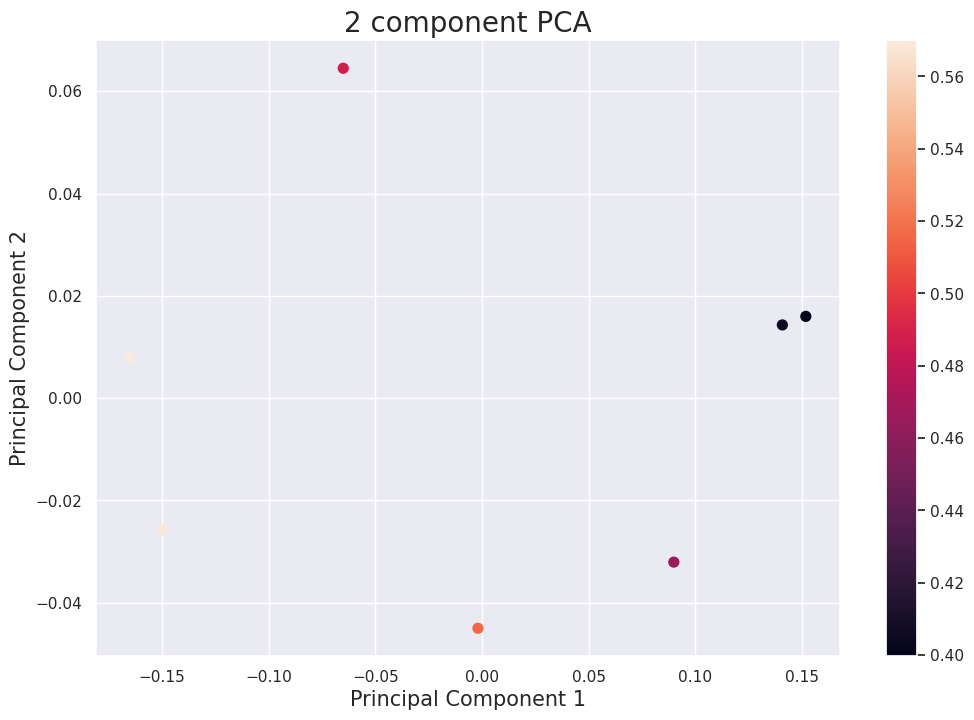

In [12]:
# Rank-based exploration-exploitation strategy.py
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 27 15:42:28 2022

@author: z.rao
"""

import os
import time
from bayes_opt import BayesianOptimization
#from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import numpy as np
#import seaborn as sns
#from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import explained_variance_score
#from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import datetime
import pandas as pd
#compute the mean and std
Comp_total = First_round_Comp_total
prediciton_mean = Comp_total.mean(axis=1)
prediciton_std = Comp_total.std(axis=1)

#20250402yayun
WAE_x=pd.read_excel('Results/First_round_ensemble_comp.xlsx')

WAE_x['prediction_mean'] = prediciton_mean
WAE_x['prediction_std'] = prediciton_std
#WAE_x['rank_score'] =prediciton_std*0.2+prediciton_mean*0.8
#WAE_x.sort_values(by=['Cr'],ascending=True)
#Comp_total = Comp_total[Comp_total['Cr']>0.04]
#WAE_x = WAE_x.sort_values(by=['prediction_mean'],ascending=True)
#Comp_total.to_csv('Results/Comp_total_1.csv')
#WAE_x.loc[(WAE_x['Cr'] > 0.04)].to_csv('Results/WAE_x_1.csv')
df = WAE_x[['Fe','Ni','Co','Cr','V','Cu','prediction_mean','prediction_std']]
df=df[(df['Fe']>0.1) & (df['Ni']>0.05)& (df['Co']>0.1)& (df['Cr']>=0.04)&(df['V']==0)  & (df['Cu']>=0.05)
      &(df['prediction_mean']<10)]
# make the ranking
df['mean_rank']=df['prediction_mean'].rank()
df['std_rank']=df['prediction_std'].rank(ascending=False)
df['total_rank'] =0.8*df['mean_rank']+0.2*df['std_rank']
df = df[df['total_rank']<1000]
#plot the figure to have a overview
x=df[['Fe','Ni','Co','Cr','V','Cu']]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
sc=plt.scatter(principalDf[ 'principal component 1']
                , principalDf['principal component 2']
               ,c=df['Fe'], s = 50)
plt.colorbar(sc)


Average negative log likelihood: -7.405604972405923


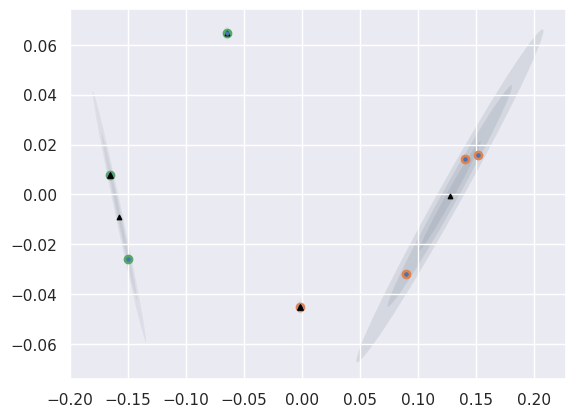

In [13]:
# PCA and AffinityPropagation.py
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 27 15:44:05 2022

@author: z.rao
"""


from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from numpy import unique, where
import matplotlib.pyplot as pyplot
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        #print('position=',position)
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle=angle, **kwargs))
def plot_gmm(gm, principalDf, label=True, ax=None):
    fig, axs = plt.subplots(1,1)
    plt.scatter(c_trans[:,0],c_trans[:,1], s = 10, c='black', marker='^',zorder=2)
    ax = axs or plt.gca()
    # labels = gm.fit(X).predict(X)
    ax.scatter(principalDf[:, 0], principalDf[:, 1], s=5, zorder=2)
    # plt.axis('equal')
    # plt.xlim(-0.16,0.27)
    # plt.ylim(-0.023,0.035)
    w_factor = 0.2 / gm.weights_.max()
    for pos, covar, w in zip(gm.means_, gm.covariances_, gm.weights_):
        draw_ellipse(pos, covar, alpha= 0.85*w * w_factor, facecolor='slategrey', zorder=-10)
    #fig.savefig('PC_GMM_1.tif', bbox_inches = 'tight', pad_inches=0.01)
def APropagation(X):
    # fig = plt.figure(figsize = (12,8))
    model = AffinityPropagation(damping=0.9)
    # 匹配模型
    model.fit(X)
    # 为每个示例分配一个集群
    yhat = model.predict(X)
    # 检索唯一群集
    clusters = unique(yhat)
    # 为每个群集的样本创建散点图
    out = np.empty([1,2])
    # plt.figure(figsize=(12,8),dpi=200)
    for cluster in clusters:
    # 获取此群集的示例的行索引
        row_ix = where(yhat == cluster)
        # 创建这些样本的散布
        pyplot.scatter(X[row_ix, 0], X[row_ix, 1],zorder=1)
        ind = np.arange(len(X[row_ix]))
        sub_ind = np.random.choice(ind, 1, replace=False)
        a= np.array(X[row_ix])[sub_ind]
        pyplot.scatter(a[0, 0], a[0, 1], s=15, c='black', marker='^',zorder=2)
        out=np.append(out,a,axis=0)
        # Out=Out.append(a, axis=1)
    pyplot.savefig('PC_AP_1.tif', bbox_inches = 'tight', pad_inches=0.01)
    return out


# 检查 principalDf 的类型，如果是 DataFrame 则转换为 NumPy 数组
if hasattr(principalDf, 'to_numpy'): #20250402yayun
    principalDf = principalDf.to_numpy()
# 否则假设它已经是 NumPy 数组，不需要转换


gm = GaussianMixture(n_components=4, random_state=0, init_params='kmeans').fit(principalDf)
print('Average negative log likelihood:', -1*gm.score(principalDf))

# 假设 c_trans 应该是聚类中心
c_trans = gm.means_  # 使用高斯混合模型的均值作为聚类中心

# 或者，如果 c_trans 应该是某些特殊的数据点
# c_trans = principalDf[special_indices]  # 特殊索引的数据点

# 然后调用 plot_gmm 函数
#print('gm=',gm,'principalDf=',principalDf)
plot_gmm(gm,principalDf)
out = APropagation(principalDf)
out = pca.inverse_transform(out)
out=pd.DataFrame(out,columns= ['Fe','Ni','Co','Cr','V','Cu'])
out=out.drop(labels=0)
out=out.round(3)
out.to_csv('DFT_C_1.csv')


In [14]:
import dill

# 保存所有变量
dill.dump_session('official_notebook_state_GPU.db')

# 在下次打开笔记本时，使用以下命令恢复所有变量。必须先修改project_root路径，确保包含HEA_COGS.Functions等自定义的包
#import dill
#dill.load_session('official_notebook_state.db')

TypeError: cannot pickle 'ConfigModuleInstance' object